In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apartments-in-riyadh/realEstate.csv


In [4]:
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
data = pd.read_csv("../input/apartments-in-riyadh/realEstate.csv", )
data.head(2)

,user_id,id,title,price,content,imgs,refresh,beds,livings,wc,area,street_width,age,last_update,ketchen,ac,furnished,location,path,district,width,length,advertiser_type,create_time,review,profileImg,UserName,iam_verified,onMarket,IsRent
0,1495817,4596035,شقة للإيجار في شارع التغلبي ، حي النظيم ، الري...,20000,1666 كل شهر,"['014958174_1659666836308.jpg', '014958178_165...","['2022-08-06', '12:22:15']",3,0.0,2,225.0,15.0,9.0,"['2022-08-06', '12:22:15']",1.0,0.0,0.0,"{'lat': 24.80093, 'lng': 46.89689, '__typename...",/شقق-للإيجار/الرياض/شرق-الرياض/حي-النظيم/شارع-...,حي النظيم,15.0,15.0,owner,"['2022-08-05', '02:44:23']",5.00,NaN,Thamer,True,17,False
1,496663,4599813,شقة للإيجار في شارع الاقتصاد ، حي الفيحاء ، ال...,25000,شقة ارضية للإيجار بحي الفيحاء شارع الاقتصاد \r...,"['004966630_1659781493595.jpg', '004966636_165...","['2022-08-06', '10:27:57']",3,1.0,2,130.0,30.0,12.0,"['2022-08-06', '10:27:56']",1.0,0.0,0.0,"{'lat': 24.687521, 'lng': 46.807558, '__typena...",/شقق-للإيجار/الرياض/شرق-الرياض/حي-الفيحاء/شارع...,حي الفيحاء,NaN,NaN,exclusive_marketer,"['2022-08-06', '10:27:56']",4.33,yes,الاركان الثابته للعقارات,True,5,True


# Drop columns that are not useful to the prediction process

In [7]:
data = data.drop(['user_id', "id", "title","content", "imgs","refresh","last_update","path","create_time","profileImg","iam_verified","UserName"], axis=1)
data.head()

,price,beds,livings,wc,area,street_width,age,ketchen,ac,furnished,location,district,width,length,advertiser_type,review,onMarket,IsRent
0,20000,3,0.0,2,225.0,15.0,9.0,1.0,0.0,0.0,"{'lat': 24.80093, 'lng': 46.89689, '__typename...",حي النظيم,15.0,15.0,owner,5.00,17,False
1,25000,3,1.0,2,130.0,30.0,12.0,1.0,0.0,0.0,"{'lat': 24.687521, 'lng': 46.807558, '__typena...",حي الفيحاء,NaN,NaN,exclusive_marketer,4.33,5,True
2,22000,3,1.0,2,200.0,25.0,NaN,0.0,0.0,0.0,"{'lat': 24.921463, 'lng': 46.80627, '__typenam...",حي الرمال,10.0,20.0,normal_marketer,4.67,15,True
3,38000,1,1.0,1,120.0,34.0,0.0,1.0,1.0,0.0,"{'lat': 24.780059, 'lng': 46.630602, '__typena...",حي العقيق,NaN,NaN,owner,4.17,165,False
4,25000,1,1.0,1,60.0,39.0,9.0,1.0,1.0,0.0,"{'lat': 24.771793, 'lng': 46.698757, '__typena...",حي التعاون,7.0,9.0,normal_marketer,4.42,48,False


# extract the latitude and longitude from the location column

In [8]:
dict_data = data['location'].to_dict()

lat = []
lang = []
for k, v in dict_data.items():
    e = eval(v)
    lat.append(e['lat'])
    lang.append(e['lng'])
    
    
data['lat'] = lat
data['long'] = lang

In [9]:
data = data.drop("location", axis=1)
data.head()

,price,beds,livings,wc,area,street_width,age,ketchen,ac,furnished,district,width,length,advertiser_type,review,onMarket,IsRent,lat,long
0,20000,3,0.0,2,225.0,15.0,9.0,1.0,0.0,0.0,حي النظيم,15.0,15.0,owner,5.00,17,False,24.800930,46.896890
1,25000,3,1.0,2,130.0,30.0,12.0,1.0,0.0,0.0,حي الفيحاء,NaN,NaN,exclusive_marketer,4.33,5,True,24.687521,46.807558
2,22000,3,1.0,2,200.0,25.0,NaN,0.0,0.0,0.0,حي الرمال,10.0,20.0,normal_marketer,4.67,15,True,24.921463,46.806270
3,38000,1,1.0,1,120.0,34.0,0.0,1.0,1.0,0.0,حي العقيق,NaN,NaN,owner,4.17,165,False,24.780059,46.630602
4,25000,1,1.0,1,60.0,39.0,9.0,1.0,1.0,0.0,حي التعاون,7.0,9.0,normal_marketer,4.42,48,False,24.771793,46.698757


In [10]:
data.shape

(6762, 19)

In [11]:
data.dtypes.value_counts()

float64    12
int64       4
object      2
bool        1
dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6762 entries, 0 to 6761
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            6762 non-null   int64  
 1   beds             6762 non-null   int64  
 2   livings          6760 non-null   float64
 3   wc               6762 non-null   int64  
 4   area             6587 non-null   float64
 5   street_width     6552 non-null   float64
 6   age              6057 non-null   float64
 7   ketchen          6745 non-null   float64
 8   ac               6743 non-null   float64
 9   furnished        6717 non-null   float64
 10  district         6762 non-null   object 
 11  width            4662 non-null   float64
 12  length           4662 non-null   float64
 13  advertiser_type  6522 non-null   object 
 14  review           6363 non-null   float64
 15  onMarket         6762 non-null   int64  
 16  IsRent           6762 non-null   bool   
 17  lat           

In [13]:
data.isna().sum()

price                 0
beds                  0
livings               2
wc                    0
area                175
street_width        210
age                 705
ketchen              17
ac                   19
furnished            45
district              0
width              2100
length             2100
advertiser_type     240
review              399
onMarket              0
IsRent                0
lat                   0
long                  0
dtype: int64

In [14]:
data.head()

,price,beds,livings,wc,area,street_width,age,ketchen,ac,furnished,district,width,length,advertiser_type,review,onMarket,IsRent,lat,long
0,20000,3,0.0,2,225.0,15.0,9.0,1.0,0.0,0.0,حي النظيم,15.0,15.0,owner,5.00,17,False,24.800930,46.896890
1,25000,3,1.0,2,130.0,30.0,12.0,1.0,0.0,0.0,حي الفيحاء,NaN,NaN,exclusive_marketer,4.33,5,True,24.687521,46.807558
2,22000,3,1.0,2,200.0,25.0,NaN,0.0,0.0,0.0,حي الرمال,10.0,20.0,normal_marketer,4.67,15,True,24.921463,46.806270
3,38000,1,1.0,1,120.0,34.0,0.0,1.0,1.0,0.0,حي العقيق,NaN,NaN,owner,4.17,165,False,24.780059,46.630602
4,25000,1,1.0,1,60.0,39.0,9.0,1.0,1.0,0.0,حي التعاون,7.0,9.0,normal_marketer,4.42,48,False,24.771793,46.698757


## impute missing values with median for mumeric data and most frequent algo from the categorical ones

In [15]:
data = data.dropna(subset=["width","length"])
data.isna().sum()

num_missing =['livings', 'street_width','age',"review"]
cat_missing = ["ac","furnished","age","ketchen","advertiser_type"]

for col in num_missing:
    data[col] = data[col].fillna(data[col].median())
    
simple_emp = SimpleImputer(strategy="most_frequent")
for col in cat_missing:
    data[col] = simple_emp.fit_transform(data[cat_missing])
    
data.isna().sum()

price              0
beds               0
livings            0
wc                 0
area               0
street_width       0
age                0
ketchen            0
ac                 0
furnished          0
district           0
width              0
length             0
advertiser_type    0
review             0
onMarket           0
IsRent             0
lat                0
long               0
dtype: int64

## remove duplicate values

In [16]:
print(data.duplicated().sum())

data = data.drop_duplicates()
print(data.duplicated().sum())

7
0


## summary stats

In [17]:
data.describe().round(2)

,price,beds,livings,wc,area,street_width,width,length,review,onMarket,lat,long
count,4655.00,4655.00,4655.00,4655.00,4655.00,4655.00,4655.00,4655.00,4655.00,4655.00,4655.00,4655.00
mean,44129.12,2.66,1.01,2.14,2600.12,23.02,17.84,47.18,4.34,39.19,24.79,46.68
std,29693.21,1.09,0.47,0.92,162873.50,13.27,35.44,1628.85,0.49,41.68,0.08,0.08
min,55.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,24.40,46.33
25%,25000.00,2.00,1.00,1.00,100.00,15.00,8.00,9.00,4.25,18.00,24.77,46.62
50%,35000.00,3.00,1.00,2.00,150.00,20.00,11.00,12.00,4.37,29.00,24.81,46.67
75%,60000.00,3.00,1.00,3.00,180.00,30.00,15.00,18.00,4.56,50.00,24.83,46.76
max,450000.00,7.00,5.00,5.00,11111100.00,100.00,1000.00,111111.00,5.00,1199.00,25.18,46.91


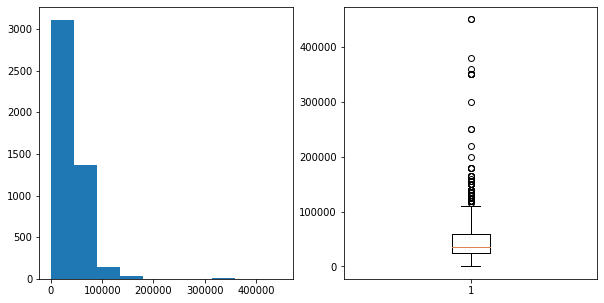

In [18]:
fig = plt.figure(figsize=(10,5))
hist = fig.add_subplot(1,2,1)
box = fig.add_subplot(1,2,2)

hist.hist(data['price'])
box.boxplot(data['price'])
sns.set()
plt.show()

# Correlatin Matrix

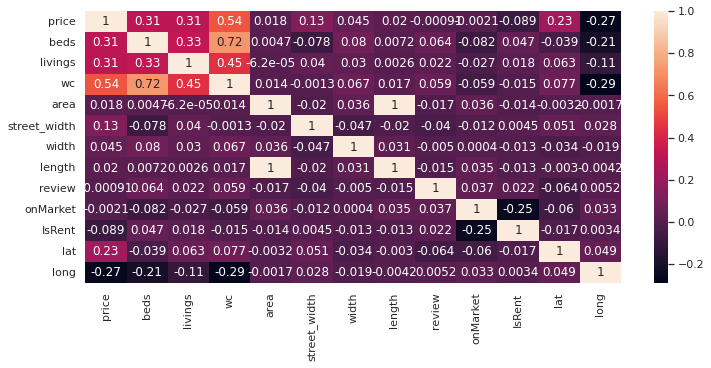

In [19]:
plt.figure(figsize=(12,5))
correlation = data.corr(method="pearson")
sns.heatmap(correlation, annot=True)
plt.show()

In [20]:
le = LabelEncoder()
data['district'] = le.fit_transform(data["district"])

# split and scale data

In [21]:
features = data.drop("price", axis=1)
target = data["price"]

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model bulding

In [22]:
lr_model = LinearRegression()


sgd_model = SGDRegressor(penalty="elasticnet",
                         alpha=0.001,
                         early_stopping=True,
                         n_iter_no_change=15,
                         random_state=42)

rf_model = RandomForestRegressor(n_estimators=400,
                                max_depth=9,
                                min_samples_leaf=3,
                                random_state=42)

xgbreg_model = xgb.XGBRegressor(n_estimators=300,
                          max_depth=10,
                          eval_metric= mean_squared_error,
                          random_state=42)

models = [lr_model, sgd_model, rf_model,xgbreg_model]
mse = []

for model in models:
    model = model.fit(X_train_scaled, y_train)
    mse.append(model.score(X_test_scaled, y_test))
    

In [23]:
mse = [round(m,3) for m in mse]

models =["Linear Regression","SGDRegressor","RandomForestRegressor","XgbRegressor"]

df_mse = pd.DataFrame({"models":models, "mse":mse})
df_mse

,models,mse
0,Linear Regression,0.334
1,SGDRegressor,0.333
2,RandomForestRegressor,0.423
3,XgbRegressor,0.328


# Predict

In [24]:
xgbreg_model.predict(X_test_scaled)[:10]

array([27191.996, 26190.861, 22779.268, 65948.91 , 26902.219, 22010.38 ,
       54974.94 , 31588.096, 33259.164, 32191.512], dtype=float32)

# Stacking Models

In [30]:
estimators = [("sgd",sgd_model),
              ("rf",rf_model)]

reg = StackingRegressor(estimators=estimators,
                        final_estimator=xgbreg_model)

reg.fit(X_train_scaled, y_train)

StackingRegressor(estimators=[('sgd',
                               SGDRegressor(alpha=0.001, early_stopping=True,
                                            n_iter_no_change=15,
                                            penalty='elasticnet',
                                            random_state=42)),
                              ('rf',
                               RandomForestRegressor(max_depth=9,
                                                     min_samples_leaf=3,
                                                     n_estimators=400,
                                                     random_state=42))],
                  final_estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                               callbacks=None,
                                               colsample_bylevel=1,
                                               colsample_bynode=1...
                                               gamma=0, gpu_id=-1,
                      

In [31]:
print(reg.score(X_test_scaled, y_test))

0.27018261640803976
